In [1]:
%load_ext autoreload
%autoreload 2

# add code directory to path
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), 'code'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from config import load_config

In [3]:
config = load_config()
embeddings = np.load(config["embeddings_path"])
sequences_df = pd.read_csv(config["substrate_specific_dataset_path"])
# use only the specific positions
sequences = sequences_df["full_seq"]
sequences = sequences.apply(lambda x: "".join([x[i - 1] for i in config["pos_to_use"]]))

Loaded configuration:
  root_path: /home/labs/fleishman/omripo/Projects/adaptive_learning
  data_dir_name: data
  pretraining_dir_name: pretraining
  bootstrap_dir_name: bootstrap
  results_dir_name: results
  enzyme: PTE
  substrate: malathion
  dataset_filename: llm_input_original_paper.csv
  tag: clustering_funclib_paper
  weights_filename: final_model.pt
  model_type: plm
  finetune: False
  opmode: mean
  train_type: msa_backbone
  nmuts_column: num_muts
  sequence_column_name: full_seq
  activity_column_name: inactive
  first_column_name: I106
  last_column_name: M317
  plm_name: esm2_t12_35M_UR50D
  ref_seq: DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALAEKAVRGLRRARAAGVRTIVDVSTFDIGRDVSLLAEVSRAADVHIVAATGLWFDPPLSMRLRSVEELTQFFLREIQYGIEDTGIRAGIIKVATTGKATPFQELVLKAAARASLATGVPVTTHTAASQRDGEQQAAIFESEGLSPSRVCIGHSDDTDDLSYLTALAARGYLIGLDHIPHSAIGLEDNASASALLGIRSWQTRALLIKALIDQGYMKQILVSNDWLFGFSSYVTNIMDVMDRVNPDGMAFIPLRVIPFLREKGVPQETLAGITVTNPARFLSPTLRAS
  bootstrap_indices_prefix: indices
  train_i

In [4]:
substrate_df = pd.read_csv(config["substrate_specific_dataset_path"])
substrate_df = substrate_df[substrate_df["design"] != -1]
fold_improvements = substrate_df["fold_improvement"]
log_fold_improvements = np.log10(fold_improvements + 1e-6)


In [5]:
from bootstrap import bootstrap_regressor, boxplot_regressor_results, get_oh_table

In [6]:
oh_funclib_df, y, design_numbers = get_oh_table(
    config["substrate_specific_dataset_path"],
    first_col=config["first_column_name"],
    last_col=config["last_column_name"],
)
embeddings_for_bootstrap = embeddings[oh_funclib_df.index,:]
y = np.log(y + 1e-6)
test_frac = 0.7

In [9]:
sequences_df

,I106,F132,H254,H257,L271,L303,F306,M317,num_muts,full_seq,inactive,pad_regions,serial_number,fold_improvement,design
0,I,F,H,H,L,L,F,M,0,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101010101010101,1.0,0
1,C,F,R,W,R,T,I,M,6,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,201020202020201,NaN,-1
2,I,F,R,H,L,T,I,M,3,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,101020101020201,NaN,-1
3,C,F,R,H,L,L,I,M,3,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,201020101010201,NaN,-1
4,L,F,R,Y,L,T,I,L,6,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,401020301020202,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,H,L,R,Y,I,T,F,M,6,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,302020303020101,NaN,-1
2156,H,L,R,W,I,L,F,L,6,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,302020203010102,NaN,-1
2157,H,F,G,W,I,L,F,L,5,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,301030203010102,NaN,-1
2158,H,F,G,W,I,T,F,L,6,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,301030203020102,NaN,-1


In [10]:
sequences_df[sequences_df["design"] != -1]
# plot n_muts histogram
plt.hist(sequences_df[sequences_df["design"] != -1]["num_muts"], bins=range(0, sequences_df["n_muts"].max() + 2))
plt.xlabel("Number of mutations")
plt.ylabel("Count")
plt.title("Histogram of number of mutations in designed sequences")
plt.show()

KeyError: 'n_muts'

<Axes: >

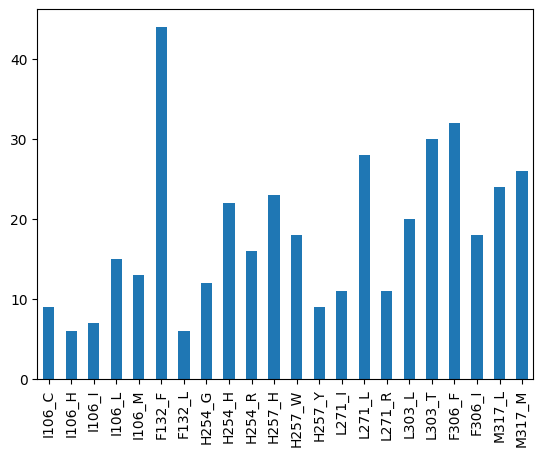

In [12]:
oh_funclib_df.loc[y.index].sum().plot(kind='bar')

In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    r2_score,
)
from scipy.stats import spearmanr

In [8]:

n_train_samples = 20
hidden_layer_size = 16

train_indices_within = np.random.choice(
    y.shape[0], size=n_train_samples, replace=False
)
train_indices_without = y.index[train_indices_within].tolist()
test_indices_within = np.setdiff1d(np.arange(y.shape[0]), train_indices_within)
test_indices_without = y.index[test_indices_within].tolist()

X_train_emb = embeddings[train_indices_without, :]
X_test_emb = embeddings[test_indices_without, :]
X_train_oh = oh_funclib_df.loc[train_indices_without].to_numpy()
X_test_oh = oh_funclib_df.loc[test_indices_without].to_numpy()
y_train = y[train_indices_without]
y_test = y[test_indices_without]
# fit the model
mlp_reg_emb = MLPRegressor(
    hidden_layer_sizes=(hidden_layer_size),
    activation="relu",
    learning_rate="invscaling",
    solver="lbfgs",
    random_state=42,
    verbose=False,
    max_iter=20000,
)
mlp_reg_oh = MLPRegressor(
    hidden_layer_sizes=(hidden_layer_size),
    activation="relu",
    learning_rate="invscaling",
    solver="lbfgs",
    random_state=42,
    verbose=False,
    max_iter=20000,
)
mlp_reg_emb.fit(X_train_emb, y_train)
mlp_reg_oh.fit(X_train_oh, y_train)
emb_predictions = mlp_reg_emb.predict(X_test_emb)
# print variance of emb_predictions
if np.var(emb_predictions) < 0.01:
    print(f"Low variance detected in embedding-based predictions: {np.var(emb_predictions)}")
    print(f"Indices used for training: {train_indices_without}")
    print(f"Indices used for testing: {test_indices_without}")
oh_predictions = mlp_reg_oh.predict(X_test_oh)
# get metrics
emb_mse = mean_squared_error(y_test, emb_predictions)
emb_r2 = r2_score(y_test, emb_predictions)
emb_spearman = spearmanr(y_test, emb_predictions).correlation
oh_mse = mean_squared_error(y_test, oh_predictions)
oh_r2 = r2_score(y_test, oh_predictions)
oh_spearman = spearmanr(y_test, oh_predictions).correlation

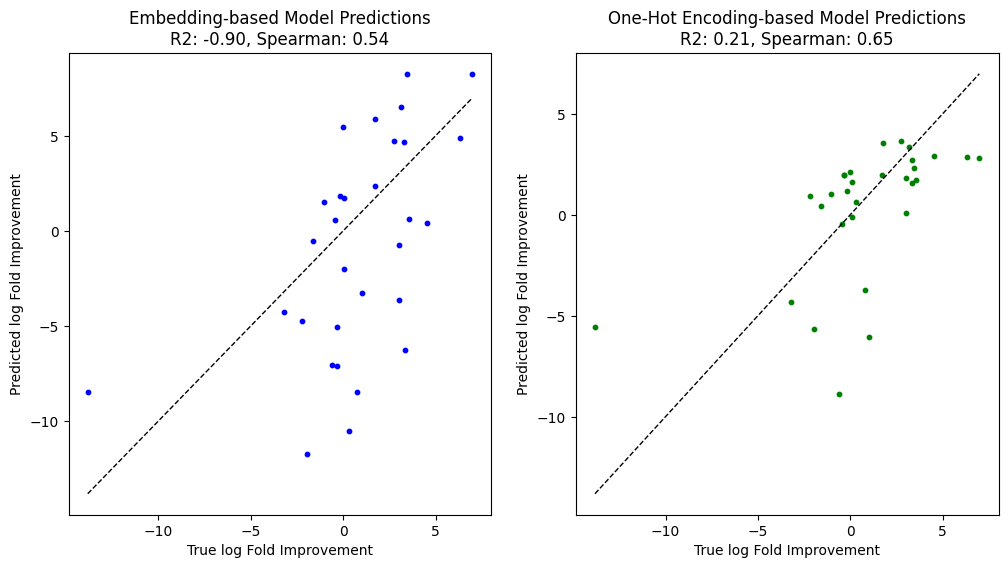

In [9]:
# plot scatter plot of true vs predicted for both models
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, emb_predictions, c="blue", s=10)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=1)
plt.xlabel("True log Fold Improvement")
plt.ylabel("Predicted log Fold Improvement")
# add spearman and r2 to the title
plt.title(f"Embedding-based Model Predictions{f'\nR2: {emb_r2:.2f}, Spearman: {emb_spearman:.2f}'}")
plt.subplot(1, 2, 2)
plt.scatter(y_test, oh_predictions, c="green", s=10)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=1)
plt.xlabel("True log Fold Improvement")
plt.ylabel("Predicted log Fold Improvement")
plt.title(f"One-Hot Encoding-based Model Predictions{f'\nR2: {oh_r2:.2f}, Spearman: {oh_spearman:.2f}'}")
plt.show()

In [21]:
from embedding import load_model, load_dataset
from dataset import EpiNNetDataset
from plm_base import plm_init
import torch

/home/labs/fleishman/omripo/Projects/adaptive_learning/.venv/lib/python3.12/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [20]:
test_indices_within

array([ 0,  2,  4,  6,  7,  8,  9, 11, 13, 15, 17, 20, 21, 22, 25, 26, 27,
       28, 31, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46])

In [29]:
train_indices_good_within = [3, 23, 29, 32, 47, 40, 41, 49, 14,  1, 24, 5, 10, 16, 12, 19, 35, 18, 30, 48]
test_indices_good_within = [0,  2,  4,  6,  7,  8,  9, 11, 13, 15, 17, 20, 21, 22, 25, 26, 27, 28, 31, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46]
train_indices_good_without = y.index[train_indices_good_within].tolist()
test_indices_good_without = y.index[test_indices_good_within].tolist()
y_train_good = y.iloc[train_indices_good_within]
y_test_good = y.iloc[test_indices_good_within]

# train_indices_bad_within = [np.int64(18), np.int64(36), np.int64(48), np.int64(23), np.int64(6), np.int64(33), np.int64(35), np.int64(3), np.int64(25), np.int64(17), np.int64(37), np.int64(9), np.int64(10), np.int64(27), np.int64(24)]
# test_indices_bad_within = np.setdiff1d(np.arange(y.shape[0]), train_indices_bad_within)
# train_indices_bad_without = y.index[train_indices_bad_within].tolist()
# test_indices_bad_without = y.index[test_indices_bad_within].tolist()
# y_train_bad = y.iloc[train_indices_bad_within]
# y_test_bad = y.iloc[test_indices_bad_within]

train_indices_bad_without = [1153, 1802, 1200, 962, 398, 143, 764, 795, 1471, 499, 923, 477, 1391, 1277, 1204, 1119, 561, 778, 20, 205]
test_indices_bad_without = [0, 13, 27, 49, 53, 97, 98, 102, 145, 214, 265, 314, 338, 358, 424, 476, 521, 537, 590, 791, 800, 891, 917, 1155, 1231, 1269, 1409, 1586, 1653, 1776]
y_train_bad = y.loc[train_indices_bad_without]
y_test_bad = y.loc[test_indices_bad_without]


In [30]:
plm_init(config["root_path"])
model = load_model(
            plm_name=config["plm_name"],
            pos_to_use=config["pos_to_use"],
            state_dict_path=config["weights_path"],
    )

In [31]:
train_dataset_bad = EpiNNetDataset(
    dataset_path=config["dataset_path"],
    indices=train_indices_bad_without,
    cache=False,
    encoding_function=model.encode,
    encoding_identifier="plm_embedding",
)
test_dataset_bad = EpiNNetDataset(
    dataset_path=config["dataset_path"],
    indices=test_indices_bad_without,
    cache=False,
    encoding_function=model.encode,
    encoding_identifier="plm_embedding",
)

Tokenizing sequences in a non-DMS dataset, this may take a while
Tokenizing sequences in a non-DMS dataset, this may take a while


In [32]:
train_dataset_good = EpiNNetDataset(
    dataset_path=config["dataset_path"],
    indices=train_indices_good_without,
    cache=False,
    encoding_function=model.encode,
    encoding_identifier="plm_embedding",
)
test_dataset_good = EpiNNetDataset(
    dataset_path=config["dataset_path"],
    indices=test_indices_good_without,
    cache=False,
    encoding_function=model.encode,
    encoding_identifier="plm_embedding",
)

Tokenizing sequences in a non-DMS dataset, this may take a while
Tokenizing sequences in a non-DMS dataset, this may take a while


In [33]:
x_train_good = train_dataset_good.encoded_tensor.to("cuda")
x_train_good_oh = oh_funclib_df.loc[train_indices_good_without]
x_test_good_oh = oh_funclib_df.loc[test_indices_good_without]
hh_train_good = model(x_train_good)
x_train_bad = train_dataset_bad.encoded_tensor.to("cuda")
x_train_bad_oh = oh_funclib_df.loc[train_indices_bad_without]
x_test_bad_oh = oh_funclib_df.loc[test_indices_bad_without]
hh_train_bad = model(x_train_bad)

In [34]:
hh_mean_train_good = torch.nn.functional.normalize(
                hh_train_good[:, torch.tensor(model.specific_pos), :], dim=1
            ).mean(dim=1)
hh_mean_train_good = hh_mean_train_good.cpu().detach().numpy()
hh_mean_train_bad = torch.nn.functional.normalize(
                hh_train_bad[:, torch.tensor(model.specific_pos), :], dim=1
            ).mean(dim=1)
hh_mean_train_bad = hh_mean_train_bad.cpu().detach().numpy()

In [ ]:
mlp_reg_emb_good = MLPRegressor(
    hidden_layer_sizes=(hidden_layer_size),
    activation="logistic",
    learning_rate="invscaling",
    random_state=42,
    verbose=True,
    max_iter=20000,
)
mlp_reg_emb_good.fit(hh_mean_train_good, y_train_good)
mlp_reg_emb_bad = MLPRegressor(
    hidden_layer_sizes=(128),
    activation="logistic",
    learning_rate="invscaling",
    learning_rate_init=0.0001,
    random_state=42,
    verbose=True,
    max_iter=20000,
)
mlp_reg_emb_bad.fit(hh_mean_train_bad, y_train_bad)

Iteration 1, loss = 9.56771764
Iteration 2, loss = 9.48413900
Iteration 3, loss = 9.40545952
Iteration 4, loss = 9.33197174
Iteration 5, loss = 9.26388346
Iteration 6, loss = 9.20131169
Iteration 7, loss = 9.14428061
Iteration 8, loss = 9.09272468
Iteration 9, loss = 9.04649565
Iteration 10, loss = 9.00537168
Iteration 11, loss = 8.96907024
Iteration 12, loss = 8.93726229
Iteration 13, loss = 8.90958691
Iteration 14, loss = 8.88566671
Iteration 15, loss = 8.86512068
Iteration 16, loss = 8.84757506
Iteration 17, loss = 8.83267249
Iteration 18, loss = 8.82007871
Iteration 19, loss = 8.80948575
Iteration 20, loss = 8.80061426
Iteration 21, loss = 8.79321455
Iteration 22, loss = 8.78706523
Iteration 23, loss = 8.78197199
Iteration 24, loss = 8.77776557
Iteration 25, loss = 8.77429955
Iteration 26, loss = 8.77144743
Iteration 27, loss = 8.76910134
Iteration 28, loss = 8.76716858
Iteration 29, loss = 8.76557081
Iteration 30, loss = 8.76424109
Iteration 31, loss = 8.76312320
Iteration 32, los

,loss,'squared_error'
,hidden_layer_sizes,128
,activation,'logistic'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'invscaling'
,learning_rate_init,0.0001
,power_t,0.9
,max_iter,20000
,shuffle,True


In [31]:
mlp_reg_emb_good.predict(embeddings[test_indices_without])

array([-1.6428019 ,  0.7166523 ,  2.4866052 , -0.50902295,  6.3221927 ,
        5.846129  ,  5.8202286 ,  1.65545   , -1.6825707 ,  0.735631  ,
        7.5331874 ,  3.558845  ,  2.4605594 , -0.09794986,  1.4042889 ,
       -0.7398689 ,  1.7298464 ,  4.171975  ,  4.11056   ,  0.3681445 ,
        3.4109254 ,  4.1900954 ,  2.3545613 , -2.7350602 ,  1.9389216 ,
       -2.1043525 , -0.4033628 , -2.2276158 , -0.72834754,  0.69575894],
      dtype=float32)

In [24]:
mlp_reg_emb_good.predict(embeddings[1200].reshape(1, -1))

array([-6.5899763], dtype=float32)

In [39]:
mlp_reg_emb_bad.predict(embeddings[test_indices_without])

array([ -3.0794399 ,   2.672485  ,   4.540723  ,   3.3587403 ,
         2.1216958 ,   0.48402855, -10.652525  ,  -2.9460368 ,
        -3.398072  ,   3.8905501 ,   3.7696624 ,  -9.194007  ,
         0.03086573,  -1.5906549 ,   2.0544548 ,   2.093077  ,
         1.5081906 ,  -1.5278742 ,   1.6222051 ,   5.730461  ,
        -0.2994575 ,  -0.05293724,   3.276322  ,   0.87580407,
         0.10621569,   3.1898303 , -13.955495  ,  -6.2827845 ,
         0.7384666 , -13.432756  ], dtype=float32)

In [123]:
mlp_reg_emb_bad.predict(embeddings[1200].reshape(1, -1))

array([-2.8604867], dtype=float32)

In [124]:
hh_test_bad = model(test_dataset_bad.encoded_tensor.to("cuda"))
hh_mean_test_bad = torch.nn.functional.normalize(
                hh_test_bad[:, torch.tensor(model.specific_pos), :], dim=1
            ).mean(dim=1)
hh_mean_test_bad = hh_mean_test_bad.cpu().detach().numpy()

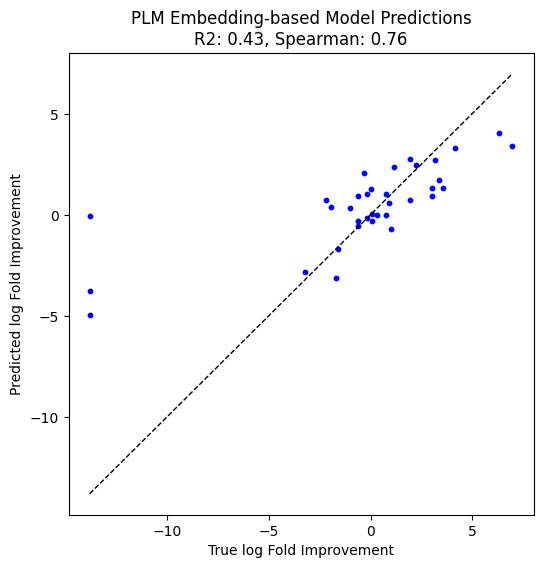

In [125]:
emb_predictions_bad = mlp_reg_emb_bad.predict(hh_mean_test_bad)
# plot scatter plot of true vs predicted for the new model
plt.figure(figsize=(6, 6))
plt.scatter(y_test_bad, emb_predictions_bad, c="blue", s=10)
plt.plot([min(y_test_bad), max(y_test_bad)], [min(y_test_bad), max(y_test_bad)], 'k--', lw=1)
plt.xlabel("True log Fold Improvement")
plt.ylabel("Predicted log Fold Improvement")
# add spearman and r2 to the title
emb_r2_new = r2_score(y_test_bad, emb_predictions_bad)
emb_spearman_new = spearmanr(y_test_bad, emb_predictions_bad).correlation
plt.title(f"PLM Embedding-based Model Predictions{f'\nR2: {emb_r2_new:.2f}, Spearman: {emb_spearman_new:.2f}'}")
plt.show()

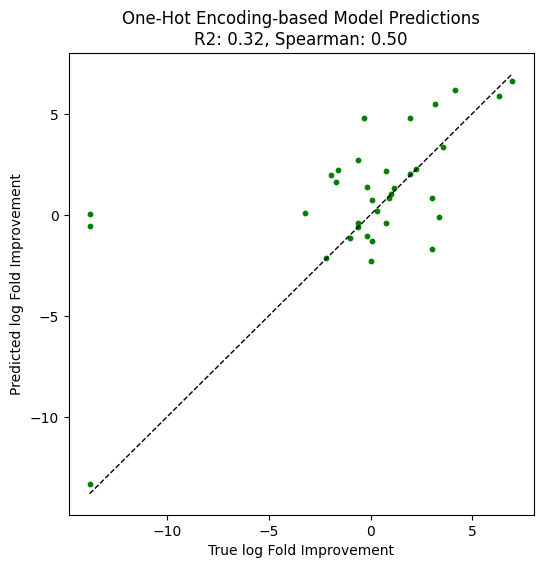

In [42]:
# fit the model
mlp_reg_oh_bad = MLPRegressor(
    hidden_layer_sizes=(hidden_layer_size),
    activation="logistic",
    learning_rate="invscaling",
    random_state=42,
    verbose=False,
    max_iter=20000,
)
mlp_reg_oh_bad.fit(x_train_good_oh, y_train_good)
oh_predictions_bad = mlp_reg_oh_bad.predict(x_test_bad_oh)
# get metrics
oh_mse = mean_squared_error(y_test_bad, oh_predictions_bad)
oh_r2 = r2_score(y_test_bad, oh_predictions_bad)
oh_spearman = spearmanr(y_test_bad, oh_predictions_bad).correlation

# plot scatter plot of true vs predicted for the new model
plt.figure(figsize=(6, 6))
plt.scatter(y_test_bad, oh_predictions_bad, c="green", s=10)
plt.plot([min(y_test_bad), max(y_test_bad)], [min(y_test_bad), max(y_test_bad)], 'k--', lw=1)
plt.xlabel("True log Fold Improvement")
plt.ylabel("Predicted log Fold Improvement")
# add spearman and r2 to the title
plt.title(f"One-Hot Encoding-based Model Predictions{f'\nR2: {oh_r2:.2f}, Spearman: {oh_spearman:.2f}'}")
plt.show()

In [45]:
y_train_bad.mean()

np.float64(1.7043580342111933)

In [44]:
y_test_bad

0       9.999995e-07
13      2.212660e+00
20      2.999226e+00
49     -6.161843e-01
53      1.931522e+00
98      3.151453e+00
102     4.163093e+00
205     7.419378e-01
214     1.029620e+00
265    -1.714793e+00
314     3.074854e-01
338    -1.743522e-01
358     3.540959e+00
476    -5.978352e-01
477    -3.424889e-01
499    -5.978352e-01
521     3.353756e+00
764    -1.609433e+00
791     1.943049e+00
795    -2.207266e+00
800     9.321645e-01
891     3.004692e+00
917     6.976983e+00
962     6.765958e-02
1200   -3.218851e+00
1204   -1.863284e-01
1231    1.172482e+00
1269    6.307843e+00
1277   -1.381551e+01
1391    6.765958e-02
1409    7.701087e-01
1471   -1.381551e+01
1586   -1.966106e+00
1653   -1.021648e+00
1802   -1.381551e+01
Name: fold_improvement, dtype: float64

In [44]:
n_iterations = 100
embeddings_r2_results = []
embeddings_spearman_results = []

good_train_indices_list = []
bad_train_indices_list = []

for i in range(n_iterations):
    train_indices_within = np.random.choice(
        y.shape[0], size=n_train_samples, replace=False
    )
    train_indices_without = y.index[train_indices_within].tolist()
    test_indices_within = np.setdiff1d(np.arange(y.shape[0]), train_indices_within)
    test_indices_without = y.index[test_indices_within].tolist()
    X_train_emb = embeddings[train_indices_without, :]
    X_test_emb = embeddings[test_indices_without, :]
    y_train = y[train_indices_without]
    y_test = y[test_indices_without]
    # fit the model
    mlp_reg_emb = MLPRegressor(
        hidden_layer_sizes=(128),
        activation="logistic",
        learning_rate="invscaling",
        random_state=42,
        verbose=False,
        max_iter=20000,
    )
    mlp_reg_emb.fit(X_train_emb, y_train)
    mlp_reg_oh.fit(X_train_oh, y_train)
    emb_predictions = mlp_reg_emb.predict(X_test_emb)
    if np.var(emb_predictions) < 0.01:
        print(f"Low variance detected in embedding-based predictions: {np.var(emb_predictions)}")
        # print indices in list format
        print(f"Indices used for training: {train_indices_without}")
        print(f"Indices used for testing: {test_indices_without}")
        bad_train_indices_list.append(train_indices_without)
        print("retraining with decreased initial learning rate")
        mlp_reg_emb = MLPRegressor(
            hidden_layer_sizes=(hidden_layer_size),
            activation="logistic",
            learning_rate="invscaling",
            random_state=42,
            verbose=False,
            max_iter=20000,
            learning_rate_init=0.0001,
        )
        mlp_reg_emb.fit(X_train_emb, y_train)
        emb_predictions = mlp_reg_emb.predict(X_test_emb)
        print(f"New variance: {np.var(emb_predictions)}")
    else:
        good_train_indices_list.append(train_indices_without)
    emb_mse = mean_squared_error(y_test, emb_predictions)
    emb_r2 = r2_score(y_test, emb_predictions)
    emb_spearman = spearmanr(y_test, emb_predictions).correlation

    embeddings_r2_results.append(emb_r2)
    embeddings_spearman_results.append(emb_spearman)

    print(
        f"Iteration {i + 1}/{n_iterations}: Embedding Spearman: {emb_spearman:.4f}"
    )

Iteration 1/100: Embedding Spearman: 0.5319
Iteration 2/100: Embedding Spearman: 0.6403
Iteration 3/100: Embedding Spearman: 0.6650
Iteration 4/100: Embedding Spearman: 0.3999
Iteration 5/100: Embedding Spearman: 0.7741
Low variance detected in embedding-based predictions: 0.00013230720651336014
Indices used for training: [314, 778, 891, 1155, 358, 476, 477, 764, 143, 27, 1231, 1204, 49, 1119, 98, 1653, 102, 1391, 13, 424]
Indices used for testing: [0, 20, 53, 97, 145, 205, 214, 265, 338, 398, 499, 521, 537, 561, 590, 791, 795, 800, 917, 923, 962, 1153, 1200, 1269, 1277, 1409, 1471, 1586, 1776, 1802]
retraining with decreased initial learning rate
New variance: 1.945239637279883e-05
Iteration 6/100: Embedding Spearman: 0.5647
Iteration 7/100: Embedding Spearman: 0.6161
Iteration 8/100: Embedding Spearman: 0.7300
Low variance detected in embedding-based predictions: 0.00028854564880020916
Indices used for training: [49, 791, 102, 1200, 537, 1391, 1153, 1155, 923, 795, 476, 590, 398, 917

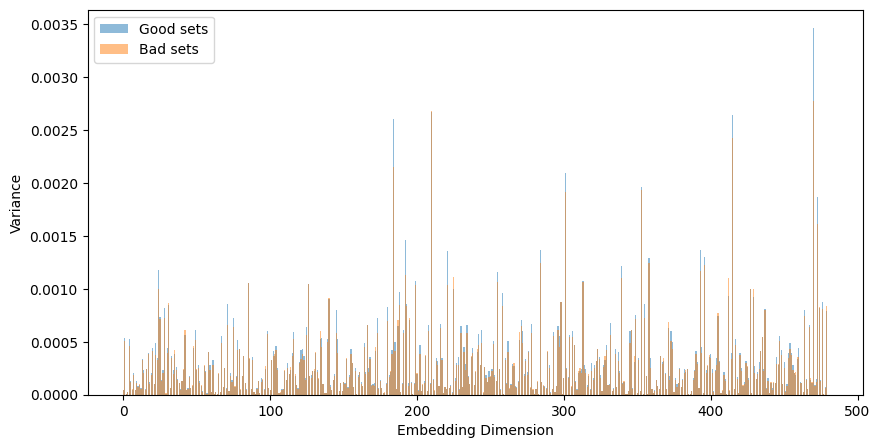

In [62]:
# check for differences between good sets and bad sets
variances_good = []
variances_bad = []

for train_indices in good_train_indices_list:
    X_train_emb = embeddings[train_indices, :]
    # check variance of the rows
    variances_good.append(X_train_emb.var(axis=0))
for train_indices in bad_train_indices_list:
    X_train_emb = embeddings[train_indices, :]
    # check variance of the rows
    variances_bad.append(X_train_emb.var(axis=0))

# plot bars of variances
plt.figure(figsize=(10, 5))
plt.bar(range(len(variances_good[0])), np.mean(variances_good, axis=0), alpha=0.5, label="Good sets")
plt.bar(range(len(variances_bad[0])), np.mean(variances_bad, axis=0), alpha=0.5, label="Bad sets")
plt.xlabel("Embedding Dimension")
plt.ylabel("Variance")
plt.legend()
plt.show()
    

In [64]:
# find bad sets intersection
intersection_set = set(bad_train_indices_list[0])
print("Bad training set:", intersection_set)
for train_indices in bad_train_indices_list[1:]:
    intersection_set = intersection_set.intersection(set(train_indices))
    print("Current intersection:", intersection_set)
print("Indices present in all bad training sets:", intersection_set)

Bad training set: {0, 1155, 265, 521, 537, 795, 923, 424, 49, 1586, 205, 590, 1231, 338, 476, 97, 358, 1391, 1776, 764}
Current intersection: {97, 764, 424, 1231, 1776, 537, 795, 476}
Current intersection: {97, 1231, 537, 795, 476}
Current intersection: {1231}
Current intersection: set()
Current intersection: set()
Current intersection: set()
Current intersection: set()
Current intersection: set()
Indices present in all bad training sets: set()


In [70]:
sequences_df.loc[bad_train_indices_list[2]]

,I106,F132,H254,H257,L271,L303,F306,M317,num_muts,full_seq,inactive,pad_regions,serial_number,fold_improvement,design
358,L,F,G,H,L,L,F,L,3,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,401030101010102,34.50,27
795,M,F,H,Y,L,L,F,L,3,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,501010301010102,0.11,41
537,L,F,H,W,I,L,F,L,4,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,401010203010102,91.73,24
477,M,F,R,W,L,L,F,L,4,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,501020201010102,0.71,46
476,M,F,G,H,L,T,I,M,4,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,501030101020201,0.55,42
561,I,L,H,W,L,T,I,L,5,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,102010201020202,5.70,6
97,L,F,R,Y,L,L,I,M,4,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,401020301010201,5.62,34
13,L,F,R,Y,L,L,F,L,4,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,401020301010102,9.14,33
49,C,F,G,H,L,T,I,L,5,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,201030101020202,0.54,11
143,C,F,H,W,L,T,F,L,4,DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,0,0_330,201010201020102,15.63,8
